<a href="https://colab.research.google.com/github/Hwismos/capstone-keras-based-model/blob/main/message-passing/MPNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 환경 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/4학년/캡스톤/[인공지능] 실습/[05.10] Keras-MPNN"

/content/drive/MyDrive/4학년/캡스톤/[인공지능] 실습/[05.10] Keras-MPNN


# Message Passing Neural Network for molecular property prediction

## Introduction
- 이번 튜토리얼에서는 Message Passing Neural Network로 알려진 Graph Neural Netowrk(GNN)을 구현한다.
    - 그래프 성질을 예측하는 것을 목적으로 한다.
- 분자 구조를 예측하는 MPNN 모델을 구축한다.
- 분자들은 자연적으로 무방향 그래프 구조로 형성된다.
    - MPNN을 이용하면 분자의 성질을 유용하게 예측할 수 있다. 
- 기존의 모델들은 분자 구조에 대한 특징들이 미리 계산되어야 했다. 즉, 유용한 특징들을 더 많이 주입할수록 더 좋은 예측이 가능해졌음을 의미했다.
    - GNN은 기존의 방식과 다르다. 


## Setup


In [ ]:
# RDKit은 분자식을 쉽게 표현할 수 있게 도와주는 라이브러리다. 
# SMILE은 주어진 분자 구조에 대해 아스키 스트링 형태로 표현해준다.


!pip -q install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 17.6 MB/s eta 0:00:00


In [ ]:
!pip -q install pandas
!pip -q install Pillow
!pip -q install matplotlib
!pip -q install pydot
!sudo apt-get -qq install graphviz

In [ ]:
import os

# Temporary suppress tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage

# Temporary suppress warnings and RDKit logs
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

np.random.seed(42)
tf.random.set_seed(42)

## Dataset
- 이용하는 데이터셋은 2,050개의 분자를 표함하고 있다.
    - 각각의 분자들은 이름과 라벨, SMILES 스트링 정보를 갖고 있다.
- 라벨의 정보는 삼투성, 투과성으로, 이러한 성질이 있을 때는 1, 없을 때는 0의 이진수 형태로 표현된다.

In [ ]:
csv_path = keras.utils.get_file(
    "BBBP.csv", "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv"
)

df = pd.read_csv(csv_path, usecols=[1, 2, 3])

# iloc 메소드는, 정수 위치 기반 인덱싱을 가능하게 해준다.
df.iloc[96:104]

148743/148743 [==============================] - 0s 1us/step


,name,p_np,smiles
96,cefoxitin,1,CO[C@]1(NC(=O)Cc2sccc2)[C@H]3SCC(=C(N3C1=O)C(O...
97,Org34167,1,NC(CC=C)c1ccccc1c2noc3c2cccc3
98,9-OH Risperidone,1,OC1C(N2CCC1)=NC(C)=C(CCN3CCC(CC3)c4c5ccc(F)cc5...
99,acetaminophen,1,CC(=O)Nc1ccc(O)cc1
100,acetylsalicylate,0,CC(=O)Oc1ccccc1C(O)=O
101,allopurinol,0,O=C1N=CN=C2NNC=C12
102,Alprostadil,0,CCCCC[C@H](O)/C=C/[C@H]1[C@H](O)CC(=O)[C@@H]1C...
103,aminophylline,0,CN1C(=O)N(C)c2nc[nH]c2C1=O.CN3C(=O)N(C)c4nc[nH...


In [ ]:
# Define features

# 원자들과 결합들에 대한 특징들을 인코딩하기 위해 Atomfeaturizer와 BondFeaturizer 클래스를 정의한다.

class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)

In [ ]:
# Generate graphs

# SMILES 스트링으로부터 그래프를 생성하기 전에 두 가지 함수를 정의한다. 
    # molecule_from_smiles, SMILE 구조를 인풋으로 받아 분자 객체를 반환한다. 이것은 RDKit에 의해 핸들링 된다. 
    # graph_from_molcule, molecule 객체를 인풋으로 받아 그래프를 반환한다. 
        # 그래프는 세 가지 튜플(분자 특징, 결합 특징, pair_indices)로 표현된다.
# 앞선 두 가지 함수를 적용해 graphs_from_smiles 함수를 구현한다. 
    # 이를 통해 SMILES 구조로부터 그래프 구조의 데이터셋을 생성한다.

def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    # list를 ragged tensor로 변환한다.
        # ragged tensor는 Dataset을 위해 사용된다. 
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )


# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(df.shape[0]))

# Train set: 80 % of data
# 인풋 데이터에 대한 타겟 데이터 결과 값을 학습한다.
train_index = permuted_indices[: int(df.shape[0] * 0.8)]
x_train = graphs_from_smiles(df.iloc[train_index].smiles)  # Input 데이터
y_train = df.iloc[train_index].p_np  # Target 데이터

# Valid set: 19 % of data
valid_index = permuted_indices[int(df.shape[0] * 0.8) : int(df.shape[0] * 0.99)]
x_valid = graphs_from_smiles(df.iloc[valid_index].smiles) 
y_valid = df.iloc[valid_index].p_np  

# Test set: 1 % of data
test_index = permuted_indices[int(df.shape[0] * 0.99) :]
x_test = graphs_from_smiles(df.iloc[test_index].smiles)
y_test = df.iloc[test_index].p_np

Name:	acetylsalicylate
SMILES:	CC(=O)Oc1ccccc1C(O)=O
BBBP:	0
Molecule:


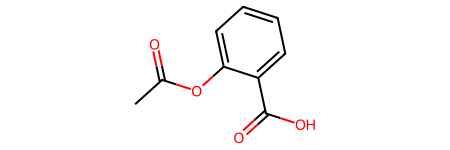

In [ ]:
# Test the functions

print(f"Name:\t{df.name[100]}\nSMILES:\t{df.smiles[100]}\nBBBP:\t{df.p_np[100]}")
molecule = molecule_from_smiles(df.iloc[100].smiles)
print("Molecule:")
molecule

In [ ]:
# Create a tf.data.Dataset

# Message Passing Neural Network(MPNN)은 iteration마다 단일 그래프를 인풋으로 받는다. 
    # 따라서, 그래프 배치(subgraph: molecules)를 생성해야 하기 때문에,
    # subgraphs를 병합한 global graph를 생성한다. 
    # global graph는 subgraph들이 분리되어 있는 disconnected graph 형태이다. 

def prepare_batch(x_batch, y_batch):
    """
    Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    # tf.data.Dataset은 인풋 데이터로부터 소스 데이터를 만들거나,
    # 데이터셋을 전처리할 때 주요 이용되는 모듈이다. 
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    
    # Dataset.batch: dataset의 연속적인 원소들을 batch로 결합시킨다.
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)

## Model
- MPNN 모델은 다양한 shapes와 forms를 취할 수 있다. 
- 본 튜토리얼의 MPNN은 message passing, readout, classification으로 구성되어 있다.

In [ ]:
# Message Passing

# MP는 두 가지 스텝으로 구성된다.
    # EdgeNetwork는, 
        # 노드 v의 1-hop 이웃 노드로부터 v에 메시지를 전달한다. 
        # 이때, 두 노드 사이의 간선의 특징에 영향을 받으며,
        # 이를 통해 v를 업데이트 한다. 
    # GatedRecurrentUnit(GRU)는,
        # 가장 최근의 노드 상태를 인풋으로 받고,
        # 이전 노드 상태들을 기반으로 하여 노드를 업데이트 시킨다.
        # 즉, 과거 노드 상태 중 가장 최신 상태와 함께,
        # 노드의 과거 상태 정보들이 수반되어 이용됨을 의미한다. 
# 위 두 스템이 k번 반복된다. 
# 이때 k가 증가함에 따라 hops의 수가 증가한다. 
    # 즉, 더 먼 이웃 노드 역시 v에 영향을 주는 것이다. 

class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    # tf.keras.layers의 Layer 모듈은 다양한 메소드를 가진다.
    # build와 call 메소드가 그것이며, 여기에서 call 메소드는 Model 모듈의 call과 다르다.
    # build 메소드는, 레이어의 변수를 생성하는데 쓰이며 서브클래싱 구현을 위해 이용된다.
    # call 메소드 전에 호출된다. 
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    # layer의 로직을 구현한다.
    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dense layer could be used here.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated

In [ ]:
# Readout

# 메시지 패싱이 끝난 뒤, 
# k번에 걸쳐 종합된 노드 상태들은 서브 그래프(각각의 배치 내의 분자)로 분할된다.
# 그리고 그래프 레벨 임베딩으로 축소된다.
# original paper와 다르게 transformer encoder + average pooling이 사용된다.
    # 각 서브 그래프는 가장 큰 노드 수를 갖는 서브 그래프에 매칭되기 위해 패딩된다.
    # 서브 그래프를 인코딩한 텐서는 패딩에 의해 영향을 받지 않도록 마스킹된다.
    # average pooling에 의해 transformer로 텐서가 전달된다. 

class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs
    ):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)

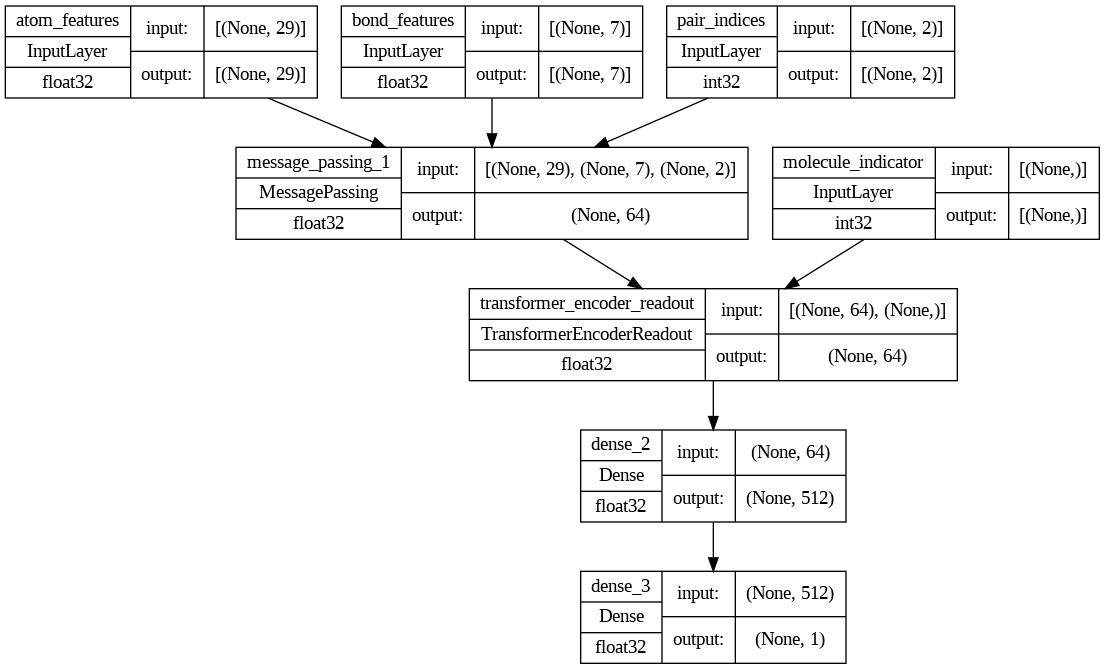

In [ ]:
# Message Passing Neural Network(MPNN)

def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size=32,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model


mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

mpnn.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.AUC(name="AUC")],
)

keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

Epoch 1/40
52/52 [==============================] - 28s 533ms/step - loss: 0.4871 - AUC: 0.7663 - val_loss: 0.4997 - val_AUC: 0.8216
Epoch 2/40
52/52 [==============================] - 28s 546ms/step - loss: 0.4567 - AUC: 0.8022 - val_loss: 0.4673 - val_AUC: 0.8350
Epoch 3/40
52/52 [==============================] - 29s 556ms/step - loss: 0.4422 - AUC: 0.8172 - val_loss: 0.4436 - val_AUC: 0.8394
Epoch 4/40
52/52 [==============================] - 24s 467ms/step - loss: 0.4291 - AUC: 0.8286 - val_loss: 0.4354 - val_AUC: 0.8394
Epoch 5/40
52/52 [==============================] - 28s 545ms/step - loss: 0.4324 - AUC: 0.8293 - val_loss: 0.4513 - val_AUC: 0.8451
Epoch 6/40
52/52 [==============================] - 27s 516ms/step - loss: 0.4158 - AUC: 0.8431 - val_loss: 0.4140 - val_AUC: 0.8356
Epoch 7/40
52/52 [==============================] - 29s 561ms/step - loss: 0.4069 - AUC: 0.8506 - val_loss: 0.4348 - val_AUC: 0.8428
Epoch 8/40
52/52 [==============================] - 28s 546ms/step - 

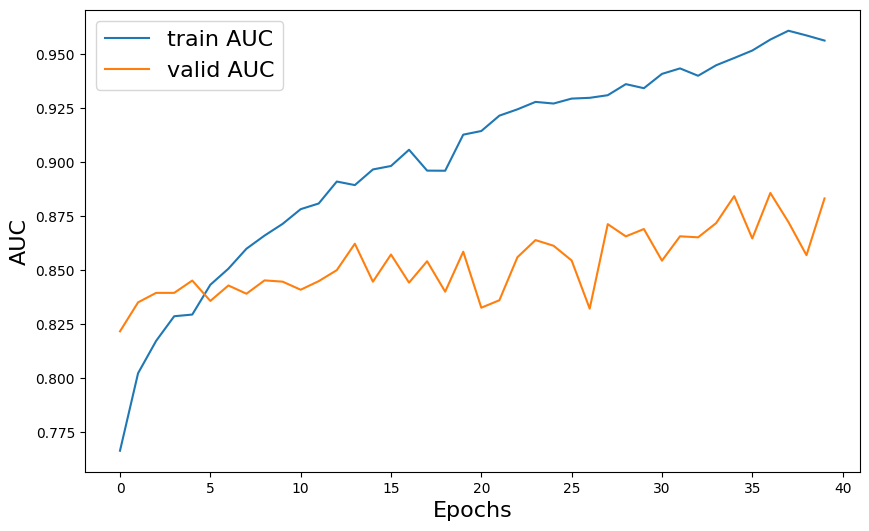

In [ ]:
# Training

train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=1,
    class_weight={0: 2.0, 1: 0.5},
)

plt.figure(figsize=(10, 6))
plt.plot(history.history["AUC"], label="train AUC")
plt.plot(history.history["val_AUC"], label="valid AUC")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("AUC", fontsize=16)
plt.legend(fontsize=16)

1/1 [==============================] - 1s 1s/step


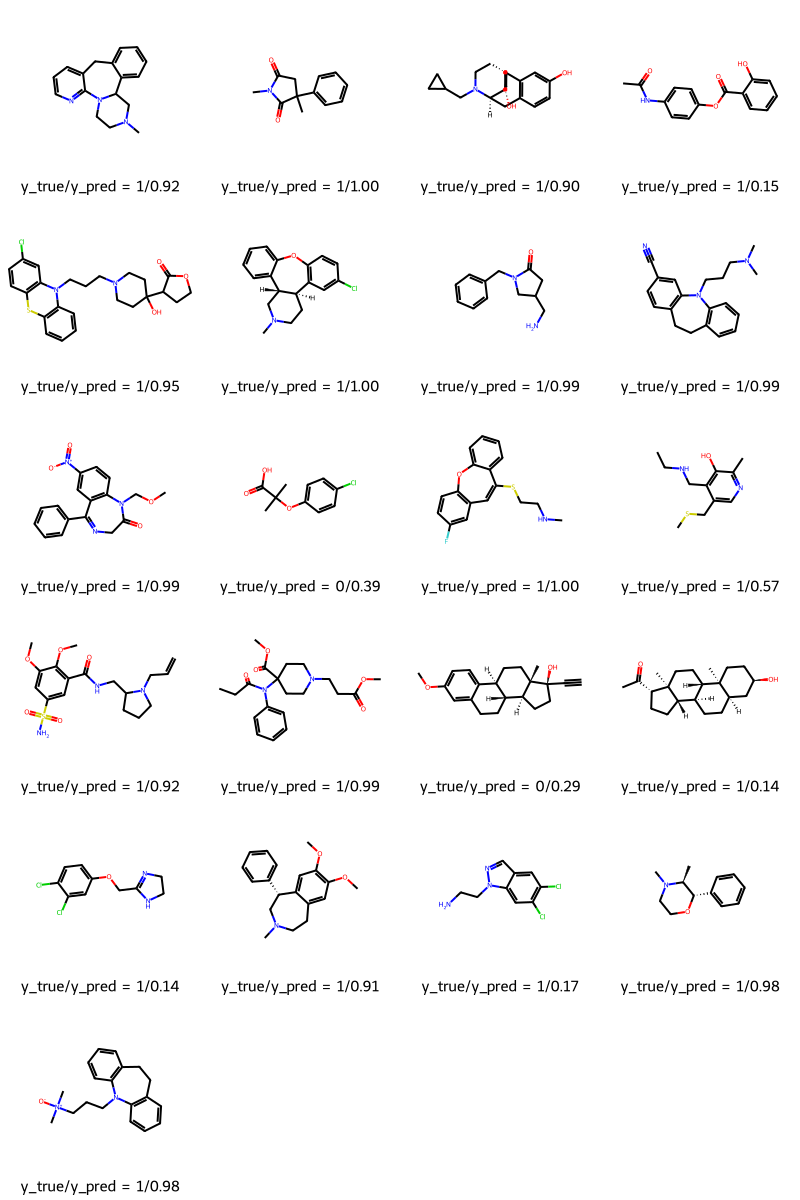

In [ ]:
# Prediction

molecules = [molecule_from_smiles(df.smiles.values[index]) for index in test_index]
y_true = [df.p_np.values[index] for index in test_index]
y_pred = tf.squeeze(mpnn.predict(test_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)